# Tarea 2: Superposición de soluciones fundamentales

## Descripción

### Problema

Se quiere realizar un programa para resolver la ecuación de Poisson

$$\nabla \phi = \rho(\mathbf{x})\, , \quad \mathbf{x}\in \mathbb{R}^2\, .$$

En donde el término fuente, $\rho$, es cero en una región acotada
del plano.

La solución de este problema puede interpretarse como el potencial
gravitacional dado por un planeta con densidad de masa uniforme y
forma arbitraria en 2 dimensiones. Alternativamente, podríamos
verlo como el potencial eléctrico dado por una distribución de carga
uniforme (en un dieléctrico). Una diferencia en el caso eléctrico es
que podemos tener una densidad positiva o negativa.

<div class="alert alert-warning">

**Solución**
    
La solución de este problema está dada por
    
$$\phi(\mathbf{x}) = \int\limits_V G(\mathbf{y}, \mathbf{x}) \rho(\mathbf{x}) dV$$
    
en donde $V$ es la región donde $\rho \neq 0$.

</div>

## Código

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshio

In [3]:
mesh = meshio.read("files/rectangle.msh")
pts = mesh.points
tris_planet = mesh.cells[0].data
tris = np.vstack([cells.data for cells in mesh.cells])
x, y, _ = pts.T

<IPython.core.display.Javascript object>


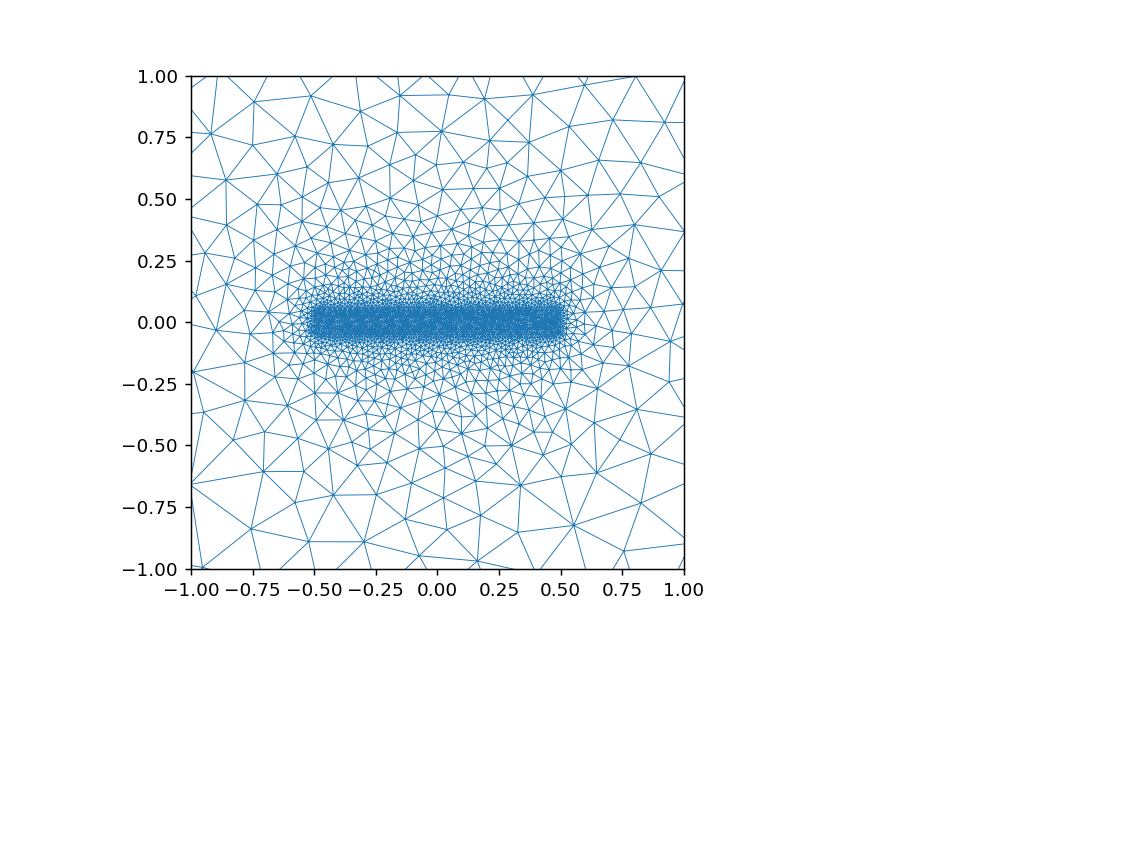

In [4]:
plt.figure()
plt.triplot(x, y, tris, lw=0.5)
plt.axis("image")
plt.xlim(-1, 1)
plt.ylim(-1, 1);

In [5]:
def green_pot_2d(r):
    """Green function for Laplace equation
    
    Parameters
    ----------
    r : float
        Distance between the two points.

    Returns
    -------
    phi : float
        Value of the potential.
    """
    return 0.5*np.log(r)/np.pi

In [6]:
def green_field_2d(r, unit_vec):
    """Derivative of the Green function for Laplace equation
    
    Parameters
    ----------
    r : float
        Distance between the two points.
    unit_vec : ndarray, float
        Unit vector from the source point to evaluation
        point.

    Returns
    -------
    E : float
        Flow field.
    """
    nx, ny = unit_vec
    Ex = -0.5*nx/(r * np.pi)
    Ey = -0.5*ny/(r * np.pi)
    return Ex, Ey

In [7]:
def area_tri(coords):
    """Compute the area of a triangle with given coordinates

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes of the triangle.

    Returns
    -------
    area : float
        Area of the triangle
    """
    mat = coords.copy()
    mat[:, 2] = 1
    return 0.5 * np.abs(np.linalg.det(mat))

In [8]:
def eval_values(eval_pts, pts, tris_planet):
    """
    
    """
    potential = np.zeros_like(eval_pts[:, 0])
    field = np.zeros_like(eval_pts[:, :2])
    for tri in tris_planet:
        coords = pts[tri]
        area = area_tri(coords)
        xm, ym, _ = np.mean(coords, axis=0)
        for cont, pt in enumerate(eval_pts):
            pt_x, pt_y = pt
            vec = np.array([pt_x - xm, pt_y - ym])
            r = np.linalg.norm(vec)
            unit_vec = vec/r
            pot = green_pot_2d(r)
            Ex, Ey = green_field_2d(r, unit_vec)
            potential[cont] += area * pot
            field[cont, :] += area * Ex, area * Ey
    return potential, field

In [9]:
potential, field = eval_values(pts[:, :2], pts, tris_planet)

<IPython.core.display.Javascript object>


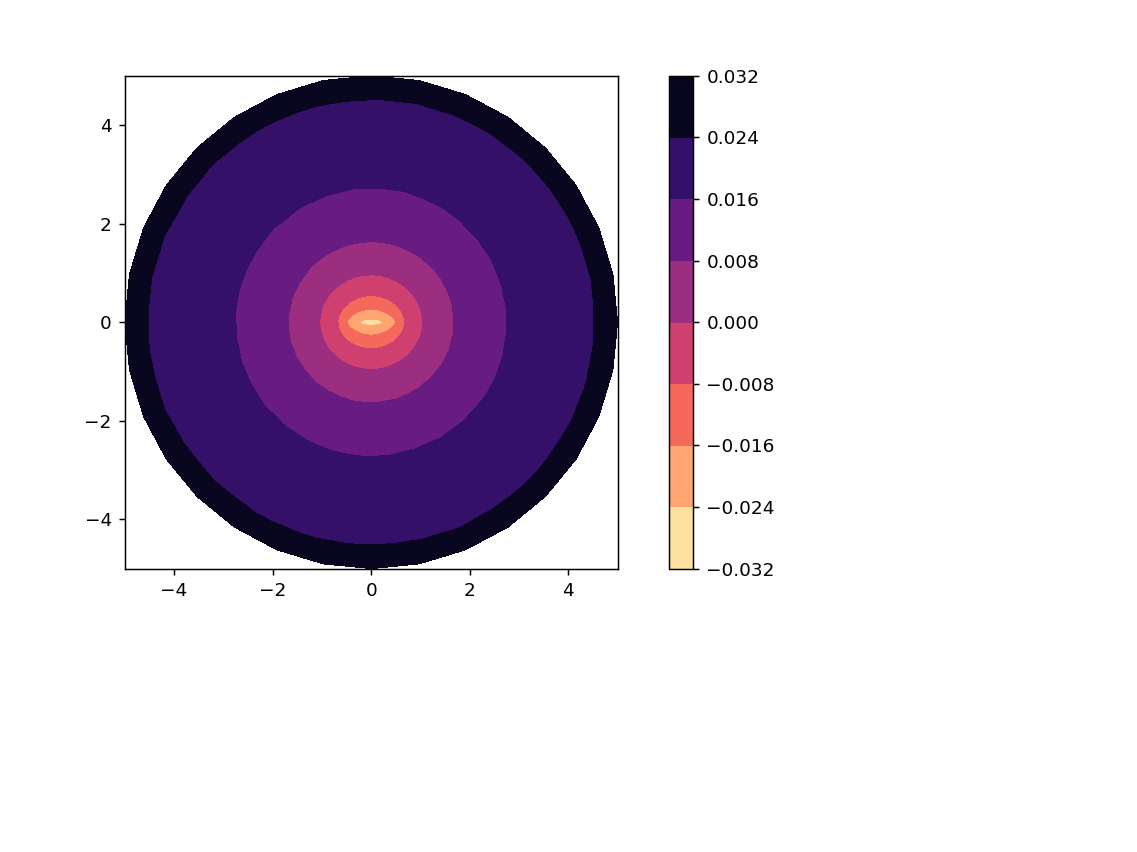

In [10]:
plt.figure()
plt.tricontourf(x, y, tris, potential, cmap="magma_r")
plt.colorbar()
plt.axis("image");

In [11]:
# Magnitud del campo
field_mag = np.linalg.norm(field, axis=1)

<IPython.core.display.Javascript object>


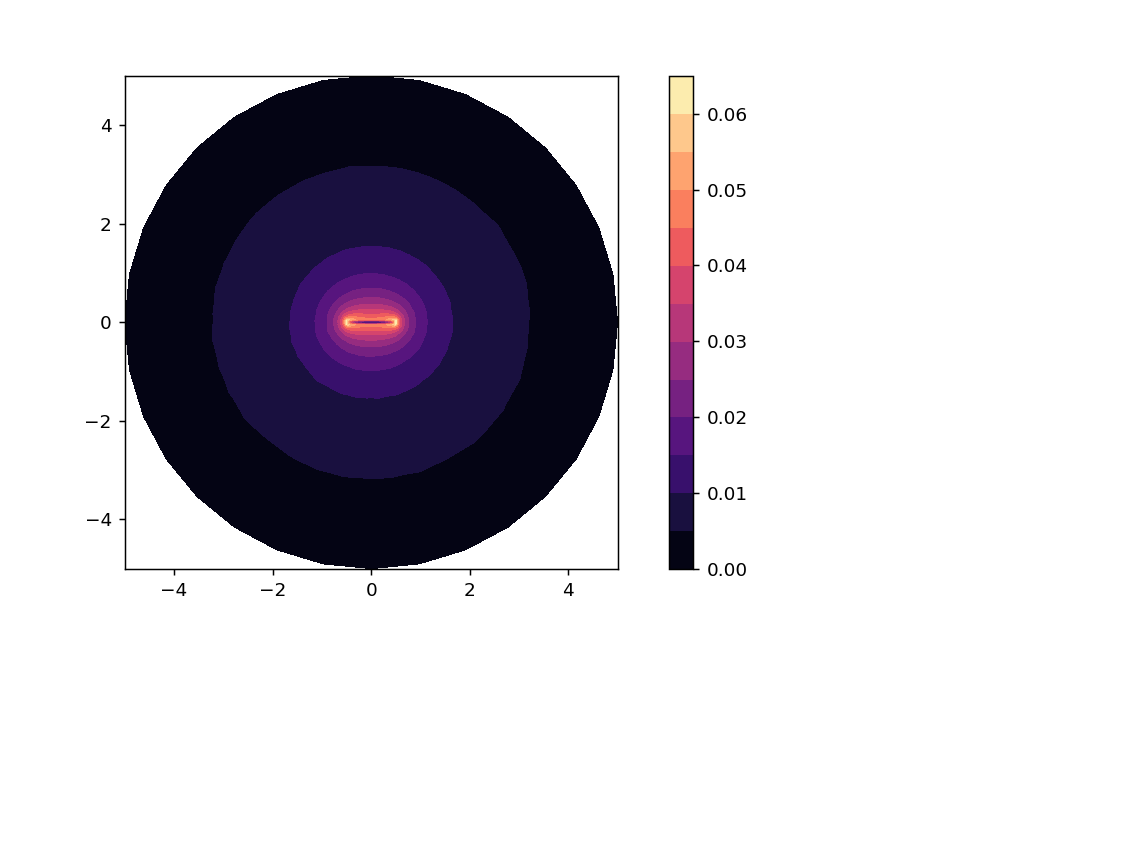

In [12]:
plt.figure()
plt.tricontourf(x, y, tris, field_mag,
                12, cmap="magma")
plt.colorbar()
plt.axis("image");

<IPython.core.display.Javascript object>


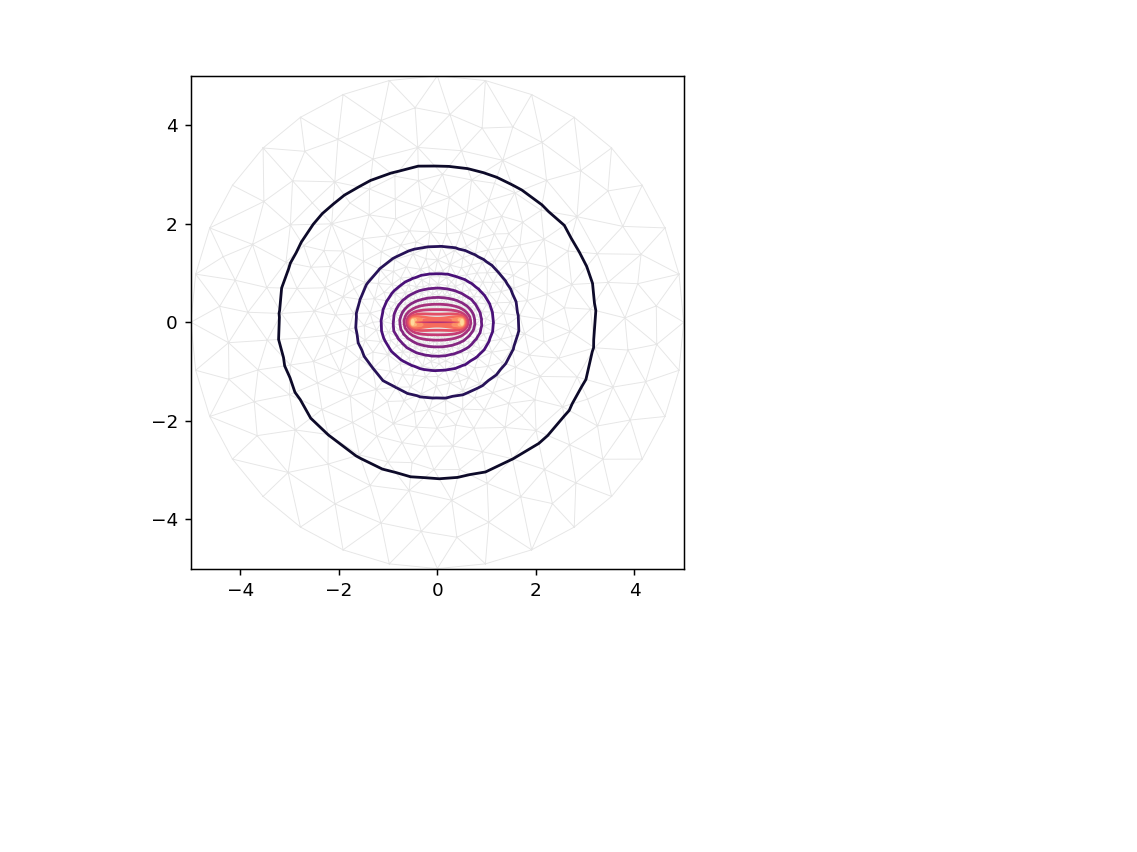

In [13]:
plt.figure()
plt.triplot(x, y, tris, lw=0.5, color="0.9")
plt.tricontour(x, y, tris, field_mag,
                 12, cmap="magma")
# plt.quiver(x, y, field[:, 0]/field_mag, field[:, 1]/field_mag,
#            units="xy", zorder=3, scale=1, width=0.03,
#            headwidth=3.0, headlength=3.0)
plt.axis("image");

## Análisis

Para ver cómo se comporta en comparación con una carga puntual vamos
a ver la variación del potencial y campo eléctricos para diferentes
ángulos. En la región cerca de la fuente debemos ver variaciones
pero en el límite cuando $r \rightarrow \infty$ debemos ver
los mismos comportamientos.

In [14]:
r_eval = np.logspace(-3, 1, 100)

In [15]:
pot0, field0 = eval_values(np.column_stack((r_eval, 0*r_eval)),
                           pts, tris_planet)
pot45, field45 = eval_values(np.column_stack((r_eval*np.sqrt(2)/2, r_eval*np.sqrt(2)/2)),
                             pts, tris_planet)
pot90, field90 = eval_values(np.column_stack((0*r_eval, r_eval)),
                             pts, tris_planet)

### Gráfico del potencial

<IPython.core.display.Javascript object>


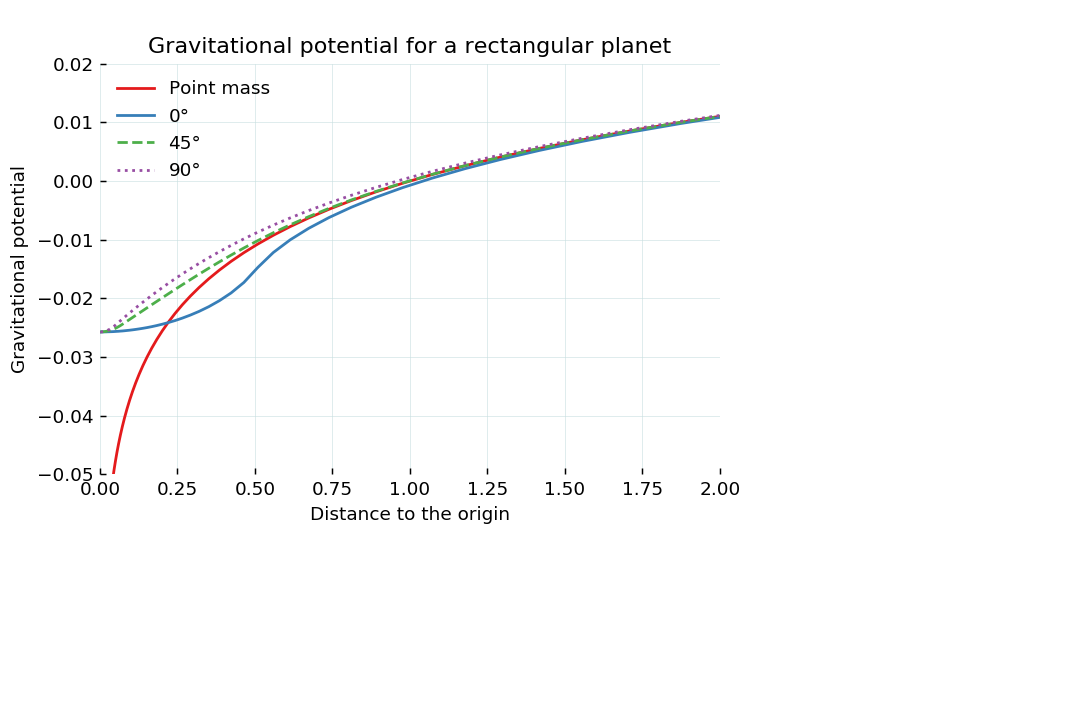

In [16]:
area = 0.1
repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
style = repo + "/styles/clean.mplstyle"
with plt.style.context(style):
    plt.figure()
    plt.plot(r_eval, 0.5 * area * np.log(r_eval)/np.pi, label="Point mass")
    plt.plot(r_eval, pot0, label="0°")
    plt.plot(r_eval, pot45, linestyle="dashed", label="45°")
    plt.plot(r_eval, pot90, linestyle="dotted", label="90°")
    plt.xlabel("Distance to the origin")
    plt.ylabel("Gravitational potential")
    plt.legend(loc="best")
    plt.xlim(0, 2)
    plt.ylim(-0.05, 0.02)
    plt.title("Gravitational potential for a rectangular planet")

### Gráfico del campo

<IPython.core.display.Javascript object>


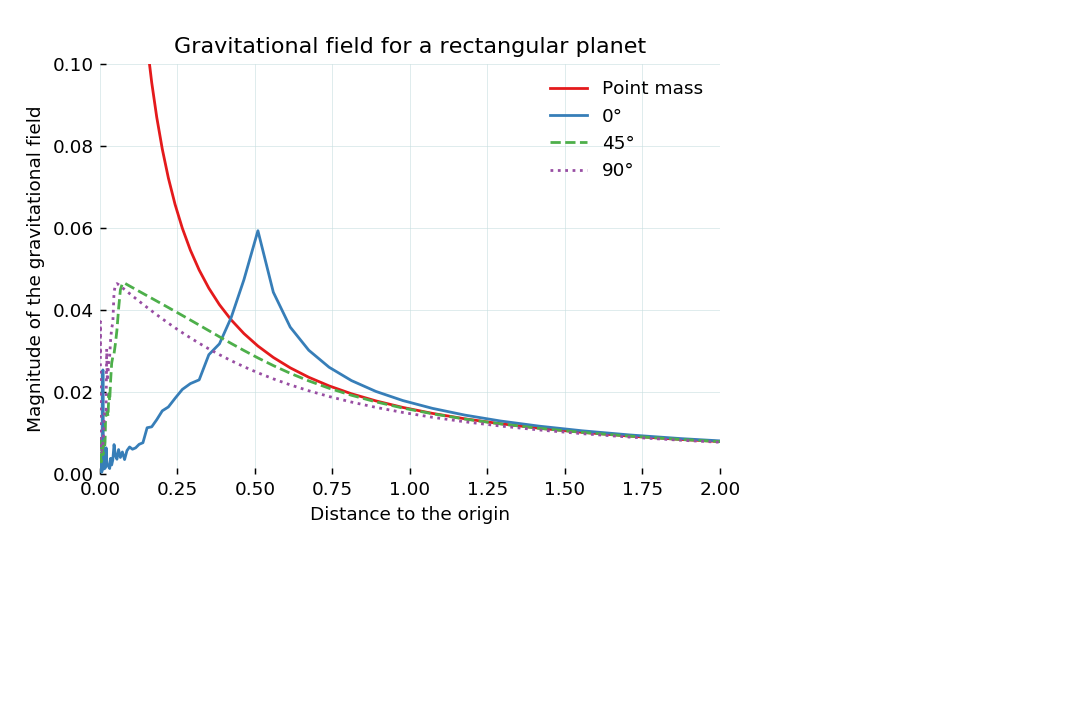

In [17]:
with plt.style.context(style):
    plt.figure()
    plt.plot(r_eval, 0.5 * area /(r_eval * np.pi), label="Point mass")
    plt.plot(r_eval, np.linalg.norm(field0, axis=1), label="0°")
    plt.plot(r_eval, np.linalg.norm(field45, axis=1), linestyle="dashed",
             label="45°")
    plt.plot(r_eval, np.linalg.norm(field90, axis=1), linestyle="dotted",
             label="90°")
    plt.xlabel("Distance to the origin")
    plt.ylabel("Magnitude of the gravitational field")
    plt.legend(loc="best")
    plt.xlim(0, 2)
    plt.ylim(0, 0.1)
    plt.title("Gravitational field for a rectangular planet")

In [18]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = 'custom.css'
HTML(open(css_file, "r").read())